# **Исследование данных о звонках операторов продающих услуги компании**

В этом блокноте я подготавливаю данные звонков для анализа, затем пытаюсь анализировать их и строю по ним воронку продаж.

Данные были взяты с сайта `https://data.fivethirtyeight.com/`.

In [74]:
from scipy import stats as st

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly import graph_objects as go

import re 
import math as mth

## Обзор данных

Посмотрим что находится в данных.

In [75]:
df = pd.read_csv("dataset.csv")

In [76]:
df

,task_rk,duratoin_sec,hit_status_result_desc,hid,using_flg,agent_login
0,196,"55,66","Дозвон, Перезвонить",1,NaN,1190lasa
1,630,0,Недозвон,4,NaN,zovadxta
2,630,0,Недозвон,4,NaN,lovaraka
3,852,189,"Дозвон, Перезвонить",1,NaN,7876nssh
4,1635,0,Недозвон,4,NaN,inovgaan
...,...,...,...,...,...,...
89169,99997999,0,Недозвон,1,NaN,9363vesh
89170,99998332,"103,88","Дозвон, Перезвонить",4,NaN,ayanyuyu
89171,99998332,0,Недозвон,4,NaN,vkiniyua
89172,99999355,"32,78","Дозвон, Отказ",4,NaN,oyansgat


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89174 entries, 0 to 89173
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   task_rk                 89174 non-null  int64  
 1   duratoin_sec            89174 non-null  object 
 2   hit_status_result_desc  89174 non-null  object 
 3   hid                     89174 non-null  int64  
 4   using_flg               2525 non-null   float64
 5   agent_login             89174 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 4.1+ MB


In [78]:
df.hit_status_result_desc.value_counts()

Недозвон                                  50461
Дозвон, Отказ                             18459
Дозвон, Перезвонить                       15108
Дозвон, Успешно                            3310
Дозвон, Отложить                           1680
Не было звонка                              130
Дозвон, Некорректное задание по звонку       26
Name: hit_status_result_desc, dtype: int64

---
## Подготовка данных

Заменим названия столбцов

In [79]:
df.columns = ["task_id", "duration_sec", "result", "product_id", "using", "agent_login"]
df.head(2)

,task_id,duration_sec,result,product_id,using,agent_login
0,196,"55,66","Дозвон, Перезвонить",1,NaN,1190lasa
1,630,0,Недозвон,4,NaN,zovadxta


Теперь названия столбцов стали понятнее
* `task_id` — идентификатор задания;
* `duratoin_sec` — продолжительность звонка;
* `result` — результата коммуникации;
* `product_id` — идентификатор продукта;
* `using` — флаг начала пользования продуктом;
* `agent_login` — логин оператора.

Удалим ненужные результаты обзвонов

In [80]:
df = df[(df["result"]!="Не было звонка") & (df["result"] != "Дозвон, Некорректное задание по звонку")]

In [81]:
df

,task_id,duration_sec,result,product_id,using,agent_login
0,196,"55,66","Дозвон, Перезвонить",1,NaN,1190lasa
1,630,0,Недозвон,4,NaN,zovadxta
2,630,0,Недозвон,4,NaN,lovaraka
3,852,189,"Дозвон, Перезвонить",1,NaN,7876nssh
4,1635,0,Недозвон,4,NaN,inovgaan
...,...,...,...,...,...,...
89169,99997999,0,Недозвон,1,NaN,9363vesh
89170,99998332,"103,88","Дозвон, Перезвонить",4,NaN,ayanyuyu
89171,99998332,0,Недозвон,4,NaN,vkiniyua
89172,99999355,"32,78","Дозвон, Отказ",4,NaN,oyansgat


Заменим тип данных в `duration_sec`

In [82]:
# Функция заменяет ',' на '.' и переведет во float
def replace_comma(dur):
    nw = []
    for i in dur:
        i = float(i.replace(",","."))
        nw.append(i)
    return nw

In [ ]:
df["duration_sec"] = replace_comma(df.loc[:,"duration_sec"])

Проверим пропуски

In [84]:
# подсчёт пропусков
df.isna().sum()

task_id             0
duration_sec        0
result              0
product_id          0
using           86493
agent_login         0
dtype: int64

В нашем случае, пропуски в `using` показывают что в клиент ещё не дошел до продукта, чтобы принять решение по его ипользованию.

Проверим дупликаты

In [85]:
print('Кол-во дубликатов =',df.duplicated(["task_id", "duration_sec", "result", "product_id", "using", "agent_login"]).sum())

Кол-во дубликатов = 402


*402 дубликатов, скорей всего эти дубликаты являются попытками оператора дозвонится до клиента и их можно спокойно удалить. Но сначала посмотрим что там:*

In [86]:
df[df.duplicated()==True].sort_values(by=["task_id", "duration_sec", "result", "product_id", "using", "agent_login"]).head(30)

,task_id,duration_sec,result,product_id,using,agent_login
231,62937,0.0,Недозвон,1,NaN,8843evod
593,169912,0.0,Недозвон,4,NaN,eevaanom
707,205167,0.0,Недозвон,4,NaN,kovantta
741,214203,0.0,Недозвон,1,NaN,2415aaty
837,248928,0.0,Недозвон,4,NaN,uluuinnu
881,265455,0.0,Недозвон,4,NaN,eevaanom
1824,587280,0.0,Недозвон,4,NaN,ryannaxa
1831,587651,0.0,Недозвон,4,NaN,6691agsa
1889,606326,0.0,Недозвон,2,NaN,5596avlo
1895,607704,0.0,Недозвон,4,NaN,2238aagr


In [87]:
df[(df["task_id"]==62937) & (df["result"]=="Недозвон")]

,task_id,duration_sec,result,product_id,using,agent_login
228,62937,0.0,Недозвон,1,NaN,kovaevsk
229,62937,0.0,Недозвон,1,NaN,8843evod
231,62937,0.0,Недозвон,1,NaN,8843evod
232,62937,0.0,Недозвон,1,NaN,tovaarbo


Видно, что одни и те же действия, по тем же заданиям, с тем же результатами повторяются. Удалим их:

In [88]:
df = df.drop_duplicates()
print('Кол-во оставшихся дубликатов =', df.duplicated().sum())

Кол-во оставшихся дубликатов = 0


Проверим:

In [89]:
print('Было строчек - 89018 /', "удалили дубликатов - 402", "Осталось строк -", (89018-402))

Было строчек - 89018 / удалили дубликатов - 402 Осталось строк - 88616


In [90]:
df = df.reset_index(drop=True)
df

,task_id,duration_sec,result,product_id,using,agent_login
0,196,55.66,"Дозвон, Перезвонить",1,NaN,1190lasa
1,630,0.00,Недозвон,4,NaN,zovadxta
2,630,0.00,Недозвон,4,NaN,lovaraka
3,852,189.00,"Дозвон, Перезвонить",1,NaN,7876nssh
4,1635,0.00,Недозвон,4,NaN,inovgaan
...,...,...,...,...,...,...
88611,99997999,0.00,Недозвон,1,NaN,9363vesh
88612,99998332,103.88,"Дозвон, Перезвонить",4,NaN,ayanyuyu
88613,99998332,0.00,Недозвон,4,NaN,vkiniyua
88614,99999355,32.78,"Дозвон, Отказ",4,NaN,oyansgat


*Всё сходится 88616 строк.*

*Вывод. Таблица готова для анализа.*

In [91]:
print('Кол-во успешных звонков =', df[df["duration_sec"]!=0]["duration_sec"].count())
sum = 0
for g in ["Дозвон, Отказ", "Дозвон, Перезвонить","Дозвон, Успешно","Дозвон, Отложить","Дозвон, Некорректное задание по звонку"]:
    users_gr = df[df["result"]==g]["result"].count()
    sum += users_gr
    print(f'Результат {g} — {users_gr} кол-во звонков')
print(f'При сложениии получается — {sum} дозвонов')

Кол-во успешных звонков = 38497
Результат Дозвон, Отказ — 18459 кол-во звонков
Результат Дозвон, Перезвонить — 15108 кол-во звонков
Результат Дозвон, Успешно — 3305 кол-во звонков
Результат Дозвон, Отложить — 1680 кол-во звонков
Результат Дозвон, Некорректное задание по звонку — 0 кол-во звонков
При сложениии получается — 38552 дозвонов


*Звонков с продолжительностью больше 0 меньше суммы всех дозвонов. Получается, что дозвоном считается звонок который клиент  отклонил*

In [92]:
df["result"].value_counts()

Недозвон               50064
Дозвон, Отказ          18459
Дозвон, Перезвонить    15108
Дозвон, Успешно         3305
Дозвон, Отложить        1680
Name: result, dtype: int64

In [93]:
df[(df["duration_sec"]==0) & (df["result"]=="Дозвон, Успешно")].head(5)

,task_id,duration_sec,result,product_id,using,agent_login
4156,1561170,0.0,"Дозвон, Успешно",4,0.0,cyanrser
4768,1755964,0.0,"Дозвон, Успешно",4,0.0,cyanrser
8729,3097008,0.0,"Дозвон, Успешно",4,0.0,cyanrser
8859,3139115,0.0,"Дозвон, Успешно",4,0.0,cyanrser
10784,3920798,0.0,"Дозвон, Успешно",4,0.0,cyanrser


# Изучиние и проверка данных

Количество уникальных заданий:

In [94]:
task = df["task_id"].nunique()
print("Заданий в таблице:", task)

Заданий в таблице: 49952


Количество операторов

In [95]:
agent = df["agent_login"].nunique()
print("Операторов в таблице:", agent)

Операторов в таблице: 1962


Среднее количество заданий на оператора

In [96]:
print("Среднее кол-во заданий на оператора =", round((task / agent), 1))

Среднее кол-во заданий на оператора = 25.5


Распределение количества заданий на операторов

In [97]:
event_per_user = df.groupby("agent_login")["task_id"].count()
event_per_user.describe()

count    1962.000000
mean       45.166157
std        32.819922
min         1.000000
25%        19.000000
50%        39.000000
75%        66.000000
max       184.000000
Name: task_id, dtype: float64

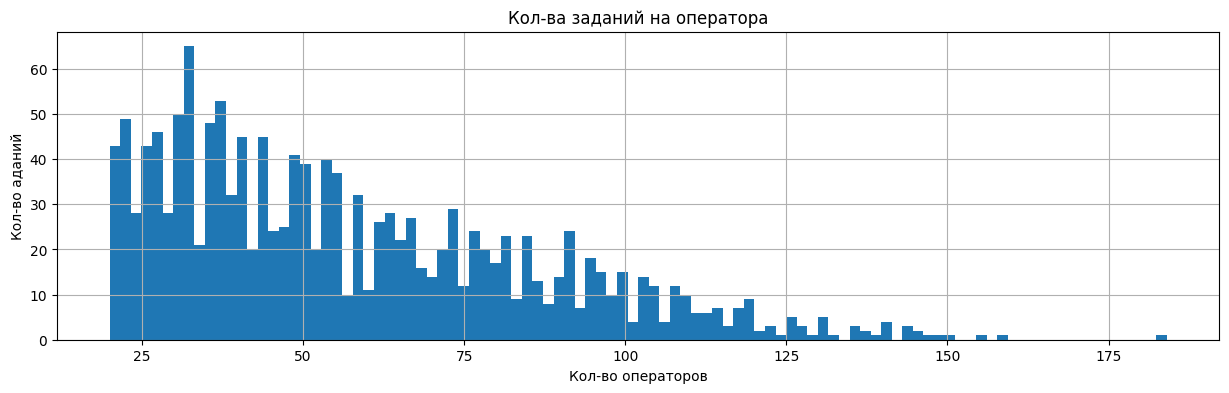

In [98]:
plt.figure(figsize=(15,4))
plt.hist(event_per_user, bins=100, range=(20,184)) 
plt.xlabel("Кол-во операторов")
plt.grid()
plt.ylabel("Кол-во аданий")
plt.title("Кол-ва заданий на оператора");

Посмотрим, какие исходы есть в логах, как часто они встречаются

In [99]:
fig = go.Figure(data=[go.Pie(labels=df['result'].value_counts().index, values=df['result'].value_counts(), \
                             title='Доли событий')])
fig.show()

*Больше половины (56.5%) исходов это - "Недозвон", вторая половина это другие 6 событий: "Дозвон, Отказ" (20.8%), "Дозвон, Перезвонить" (17%), "Дозвон, Успешно" (3.73%) и "Дозвон, Отложить" (1.9%).*

Операторы и результаты

In [100]:
result_agent = df.groupby("result").agg({"result":"count", "agent_login":"nunique", "duration_sec":"mean"}).sort_values(by="agent_login", ascending=False)
result_agent.columns = ["n_results", "agent", "mean_dur"]
result_agent = result_agent.reset_index()
result_agent["user_part_1result"] = (result_agent["agent"] / df["agent_login"].nunique() * 100).round(1) # доля операторов хотя бы раз совершивших получавших оодин из результатов
result_agent["mean_dur"] = round(result_agent["mean_dur"], 1)
result_agent

,result,n_results,agent,mean_dur,user_part_1result
0,Недозвон,50064,1831,0.0,93.3
1,"Дозвон, Отказ",18459,1816,112.5,92.6
2,"Дозвон, Перезвонить",15108,1755,112.1,89.4
3,"Дозвон, Успешно",3305,1288,110.3,65.6
4,"Дозвон, Отложить",1680,663,122.8,33.8


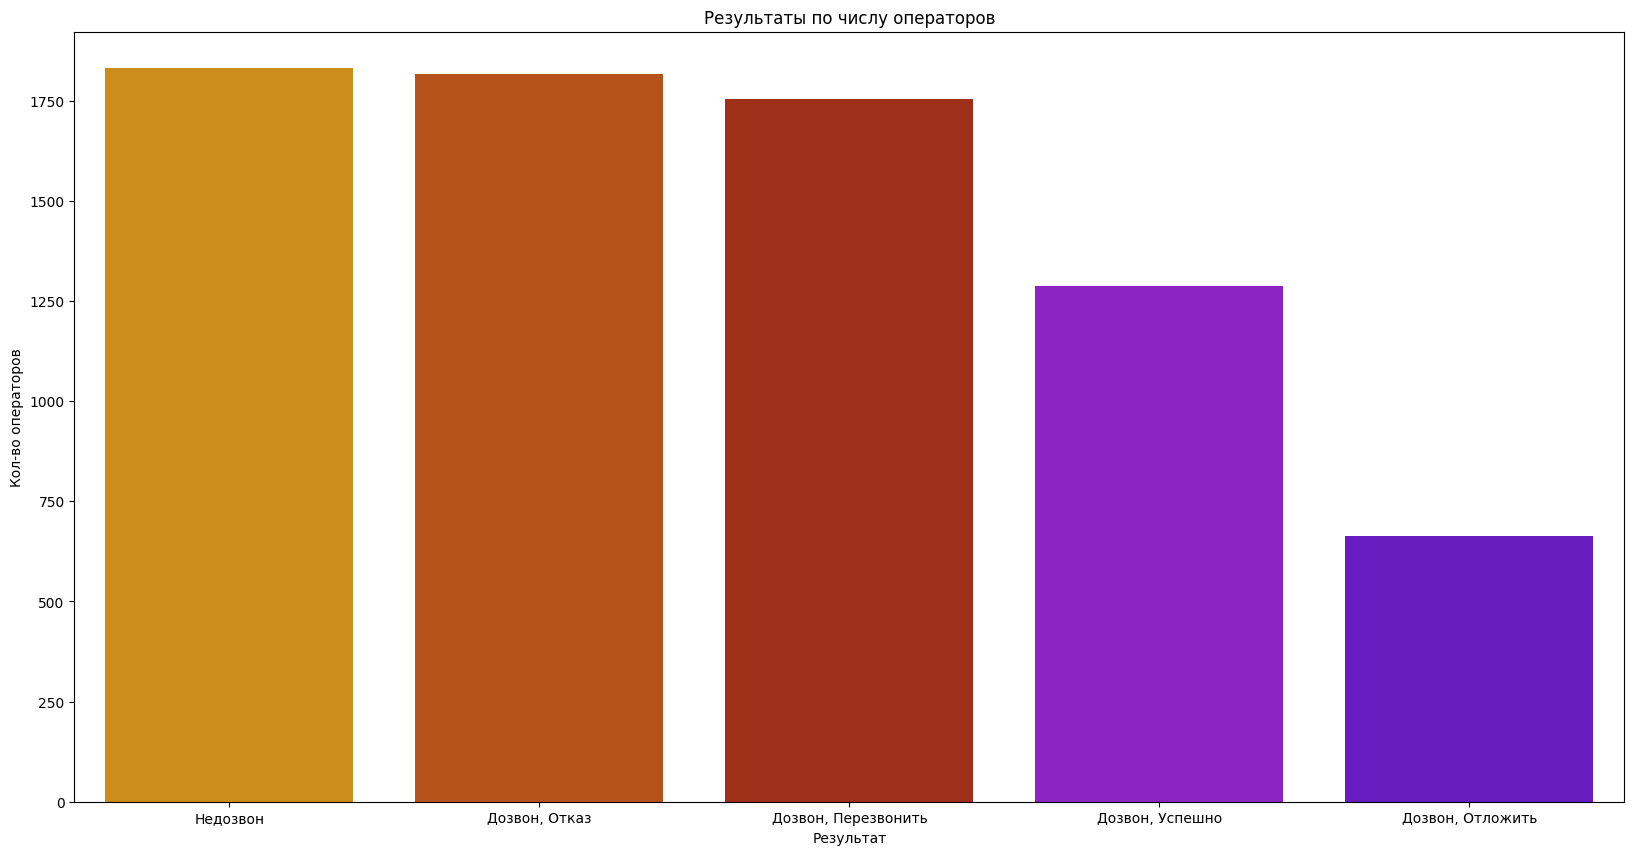

In [101]:
plt.figure(figsize=(20,10))
sns.barplot(y="agent", x="result", data=result_agent, palette="gnuplot_r");
plt.xlabel("Результат")
plt.ylabel("Кол-во операторов")
plt.title("Результаты по числу операторов")
plt.show();

## Изучение воронки продаж

Для изучения воронки необходимо выстроить последовательность событий:
* Звонок клиенту
* Дозвон до клиента
* Результат дозвона — Успех
* Начало использования продукта клиентом

In [102]:
calls = len(df)
print("Всего звонков клиентам —", calls)
accept_call = len(df[df["result"]!="Недозвон"])
print("Дозвонов до клиентов —", accept_call)
succsess = len(df[df["result"]=="Дозвон, Успешно"])
print("Успешных дозвонов до клиентов —", succsess)
product_use = len(df[df["using"]==1])
print("Клиентов начавших использовать продукт —", product_use)

Всего звонков клиентам — 88616
Дозвонов до клиентов — 38552
Успешных дозвонов до клиентов — 3305
Клиентов начавших использовать продукт — 1534


In [103]:
agent_calls = df["agent_login"].nunique()
print("Всего операторов —", agent_calls)
agent_accept_call = df[df["result"]!="Недозвон"]["agent_login"].nunique()
print("Опраторов дозвонов до клиентов —", agent_accept_call)
agent_succsess = df[df["result"]=="Дозвон, Успешно"]["agent_login"].nunique()
print("Операторов успешно дозвонившихся до клиентов —", agent_succsess)
agent_product_use = df[df["using"]==1]["agent_login"].nunique()
print("Операторов добившихся начала использования продукта —", agent_product_use)

Всего операторов — 1962
Опраторов дозвонов до клиентов — 1919
Операторов успешно дозвонившихся до клиентов — 1288
Операторов добившихся начала использования продукта — 882


Создадим датафрейм с полученными данными и посмотрим на воронку

In [104]:
events = pd.DataFrame({"event":["Звонков", "Дозвон", "Успешных дозвон", "Использование продукта"],
                       "quantity":[calls, accept_call, succsess, product_use],
                       "agent":[agent_calls, agent_accept_call, agent_succsess, agent_product_use]})
events

,event,quantity,agent
0,Звонков,88616,1962
1,Дозвон,38552,1919
2,Успешных дозвон,3305,1288
3,Использование продукта,1534,882


In [105]:
fig = go.Figure(go.Funnel(x = events["agent"], y = events["event"], textinfo = "value+percent initial+percent previous"))
fig.show();

*Plot1.png*

1) Теперь рассчитаем сколько процентов переходит на каждый последующий шаг относительно предыдущего — столбец `welcome_from_last`;
2) И также добавим столбец с кол-вом операторов в процентах, которые переходили на последующее событие относительно изначального числа операторов — столбец `welcome_from_start`:

In [106]:
prev_event = events.loc[0,"agent"]
start_event = prev_event

for i in events.index:
    events.loc[i,"welcome_from_last"] = round(events.loc[i, "agent"] / prev_event * 100, 1)
    events.loc[i,"welcome_from_start"] = round(events.loc[i,"agent"] / start_event * 100, 1)
    prev_event = events.loc[i, "agent"]
events


,event,quantity,agent,welcome_from_last,welcome_from_start
0,Звонков,88616,1962,100.0,100.0
1,Дозвон,38552,1919,97.8,97.8
2,Успешных дозвон,3305,1288,67.1,65.6
3,Использование продукта,1534,882,68.5,45.0


* Столбец `welcome_from_last` - доля пользователей перешедших с предыдущего этапа
* Столбец `welcome_from_start` - доля пользователей с первоначального этапа

Построим воронку — какой процент клиентов прошел на следующий этап относительно предцдущего

In [107]:
fig = go.Figure(go.Funnel(x = events["welcome_from_last"], y = events["event"]))
fig.show();

*Plot2.png*

*ВЫВОД: Из воронки видно, что у 32.9% операторов не получается сделать дозвон успешным. Возможно есть какая-то проблема с самой услугой, которую предлагает оператор. Также видно, что успешность дозвона не гарантирует использование клиентом продукта.*

Построим воронку — какой процент операторов перешел на следующий этап относительно первого этапа воронки:

In [108]:
fig = go.Figure(go.Funnel(x = events["welcome_from_start"], y = events["event"]))
fig.show();

*Plot3.png*

*Из этой воронки видно, что 45% операторов способны сделать так, что бы клиент начал пользоваться услугой. Очень хороший результат - почти половина, учитывая, то что 31.8% не могут добится успеха в дозвоне!*

Построим воронку — кол-во звонков на этапах продаж:

In [109]:
fig = go.Figure(go.Funnel(y = events["event"], x = events["quantity"], textinfo = "value+percent initial+percent previous"))
fig.show();

*Plot4.png*

*Данная воронка не имеет практической пользы, так как мы не знаем какам клиентам были совершены звонки и сколько звонков одним и темже клиентам повторялись. Но мы можем заметить, что 46% успешных звонков способны сделать так, что бы клиент начал пользоваться услугой.*

---
## Выводы
Воронка продаж:

Идет по следующему порядку:

1) Звонок клиенту — Это самое популярное событие (88616 раз)
2) Дозвон — Разговор клиента и оператора
3) Успешный дозвон — Привлечение внимания клиента к услуге
4) Использование услуги — Клиенты стали пользоваться услугой

На третьем этапе воронки 65,6% операторов удается продолжить работу с клиентом, а 34,4% не могут пройти дальше разговора с клиентом. Это большая цифра и здесь необходимо выянить почему так происходит, наверняка есть возможность исправить ситуацию;

Пройдя по воронке, до "Использование продукта" доводят 2% звонков. Если брать просто кол-во операторов которые смогли дойти до "Использование продукта", то этот показатель аж 45%.